# AGU 25 Additional

Load DA spatial stats from three experiments and plot total observations per month, plus per-group time series including CYGNSS.


In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

plt.close('all')

In [2]:
# File paths
p_main = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/M21C_land_sweeper/LS_DAv8_M36_v2/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_DA_200006_202405.pkl')
p_dedup = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/M21C_land_sweeper/LS_DAv8_M36_v2/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_DA_dedup_200006_202405.pkl')
p_cygnss = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_all/DAv8_M36_cd_all/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_DA_fixed_201808_202406.pkl')

species_main = {
    "SMOS": [0, 1, 2, 3],
    "SMAP": [4, 5, 6, 7],
    "ASCAT": [8, 9, 10],
    "MODIS": [11, 12],
}

species_cygnss = {
    "CYGNSS": [11],
    "SMAP": [4, 5, 6, 7],
    "ASCAT": [8, 9, 10],
    "SMOS": [0, 1, 2, 3],
}

In [3]:
def load_stats(path: Path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    dt_raw = data.get('date_vec')
    if dt_raw is None:
        date_vec = None
    else:
        date_vec = pd.to_datetime(dt_raw, format='%Y%m', errors='coerce')
        # fallback if format didn't parse
        if getattr(date_vec, "isna", lambda: False)().all():
            date_vec = pd.to_datetime(dt_raw)
    return data, date_vec


def convert_stats_dict_to_arrays(stats_dict):
    arr = {}
    for key, val in stats_dict.items():
        arr[key] = np.array(val)
        if arr[key].dtype == object:
            cleaned = []
            for row in arr[key]:
                cleaned.append([np.nan if x == '--' else float(x) for x in row])
            arr[key] = np.array(cleaned, dtype=float)
    return arr


def calculate_weighted_group_stats(stats_dict, species_groups):
    n_times = len(stats_dict['OmF_mean'])
    stats = ['O_mean','F_mean','OmF_mean', 'OmF_stdv', 'OmA_mean', 'OmA_stdv']
    group_stats = {g: {s: np.full(n_times, np.nan) for s in stats} for g in species_groups}
    for g in species_groups:
        group_stats[g]['N_data'] = np.full(n_times, np.nan)
    for t in range(n_times):
        for group, idxs in species_groups.items():
            weights = stats_dict['N_data'][t, idxs]
            total_w = np.nansum(weights)
            if total_w > 0:
                for stat in stats:
                    vals = stats_dict[stat][t, idxs]
                    group_stats[group][stat][t] = np.average(vals, weights=weights)
                group_stats[group]['N_data'][t] = total_w
    return group_stats


def align_to_dates(date_vec, series, target_index):
    s = pd.Series(series, index=date_vec)
    return s.reindex(target_index).to_numpy()


In [4]:
# Load
stats_main, dates_main = load_stats(p_main)
stats_dedup, dates_dedup = load_stats(p_dedup)
stats_cygnss, dates_cygnss = load_stats(p_cygnss)

stats_main_arr = convert_stats_dict_to_arrays(stats_main)
stats_dedup_arr = convert_stats_dict_to_arrays(stats_dedup)
stats_cygnss_arr = convert_stats_dict_to_arrays(stats_cygnss)

# Grouped time series
group_main = calculate_weighted_group_stats(stats_main_arr, species_main)
group_dedup = calculate_weighted_group_stats(stats_dedup_arr, {'ASCAT': species_main['ASCAT']})
group_cygnss = calculate_weighted_group_stats(stats_cygnss_arr, {'CYGNSS': species_cygnss['CYGNSS']})

# Common date axis (union)
target_dates = pd.DatetimeIndex(sorted(set(dates_main) | set(dates_dedup) | set(dates_cygnss)))

# Assemble combined per-group N_data
combined = {}
combined['SMOS'] = align_to_dates(dates_main, group_main['SMOS']['N_data'], target_dates)
combined['SMAP'] = align_to_dates(dates_main, group_main['SMAP']['N_data'], target_dates)
combined['MODIS'] = align_to_dates(dates_main, group_main['MODIS']['N_data'], target_dates)
combined['ASCAT'] = align_to_dates(dates_dedup, group_dedup['ASCAT']['N_data'], target_dates)
combined['CYGNSS'] = align_to_dates(dates_cygnss, group_cygnss['CYGNSS']['N_data'], target_dates)

# Replace zeros with NaN
for g in combined:
    arr = combined[g]
    combined[g] = np.where(arr == 0, np.nan, arr)

# Total obs per month
total_obs = np.nansum(np.vstack(list(combined.values())), axis=0)

# Drop the last month for plotting
target_dates_plot = target_dates[:-1]
combined_plot = {k: v[:-1] for k, v in combined.items()}
total_obs_plot = total_obs[:-1]


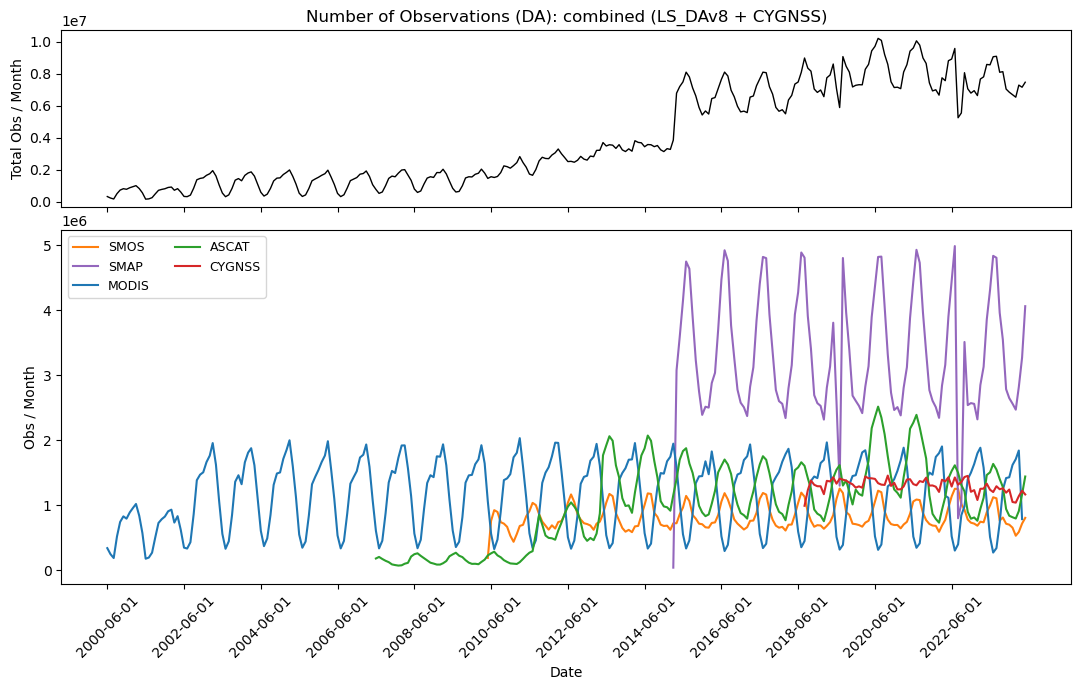

In [5]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(11, 7), sharex=True, height_ratios=[1, 2])

palette = {"MODIS": '#1f77b4', "ASCAT": '#2ca02c', "SMOS": '#ff7f0e', "SMAP": '#9467bd', "CYGNSS": '#d62728'}

ax_top.plot(target_dates_plot, total_obs_plot, color='k', lw=1)
ax_top.set_ylabel('Total Obs / Month')
ax_top.set_title('Number of Observations (DA): combined (LS_DAv8 + CYGNSS)')
ax_top.tick_params(labelbottom=False)

for group, arr in combined_plot.items():
    ax_bottom.plot(target_dates_plot, arr, label=group, color=palette.get(group, None))

ax_bottom.set_ylabel('Obs / Month')
ax_bottom.set_xlabel('Date')
ax_bottom.legend(ncol=2, fontsize=9)
ax_bottom.set_xticks(target_dates_plot[::max(len(target_dates_plot)//12,1)])
ax_bottom.tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=0.2)
plt.show()


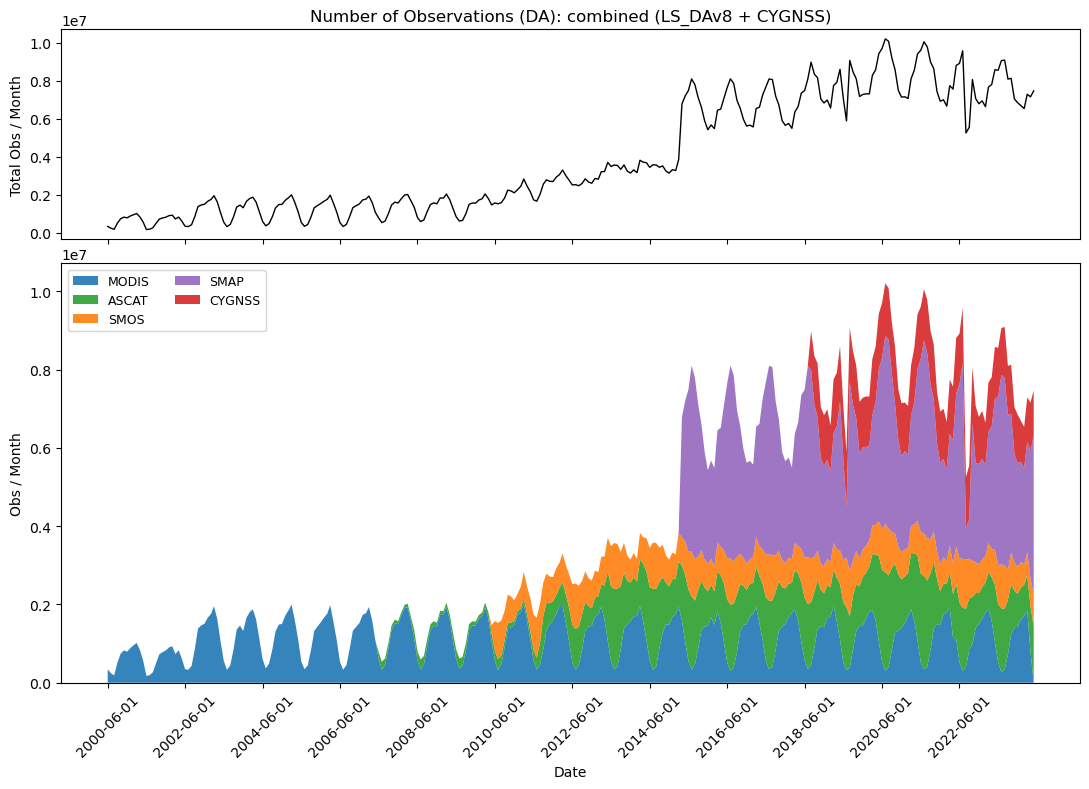

In [6]:
# Stacked area with sensor start ordering (MODIS → ASCAT → SMOS → SMAP → CYGNSS)
palette = {'MODIS': '#1f77b4', 'ASCAT': '#2ca02c', 'SMOS': '#ff7f0e', 'SMAP': '#9467bd', 'CYGNSS': '#d62728'}
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(11, 8), sharex=True, height_ratios=[1, 2])

ax_top.plot(target_dates_plot, total_obs_plot, color='k', lw=1)
ax_top.set_ylabel('Total Obs / Month')
ax_top.set_title('Number of Observations (DA): combined (LS_DAv8 + CYGNSS)')
ax_top.tick_params(labelbottom=False)

series_order = ['MODIS', 'ASCAT', 'SMOS', 'SMAP', 'CYGNSS']
stack_data = []
labels = []
for g in series_order:
    if g in combined_plot:
        arr = combined_plot[g]
        filled = np.where(np.isfinite(arr), arr, 0.0)  # keep zeros before sensor starts
        stack_data.append(filled)
        labels.append(g)

ax_bottom.stackplot(target_dates_plot, stack_data, labels=labels, colors=[palette[g] for g in labels], alpha=0.9)
ax_bottom.set_ylabel('Obs / Month')
ax_bottom.set_xlabel('Date')
ax_bottom.legend(ncol=2, fontsize=9)
ax_bottom.set_xticks(target_dates_plot[::max(len(target_dates_plot)//12,1)])
ax_bottom.tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=0.3)
plt.show()

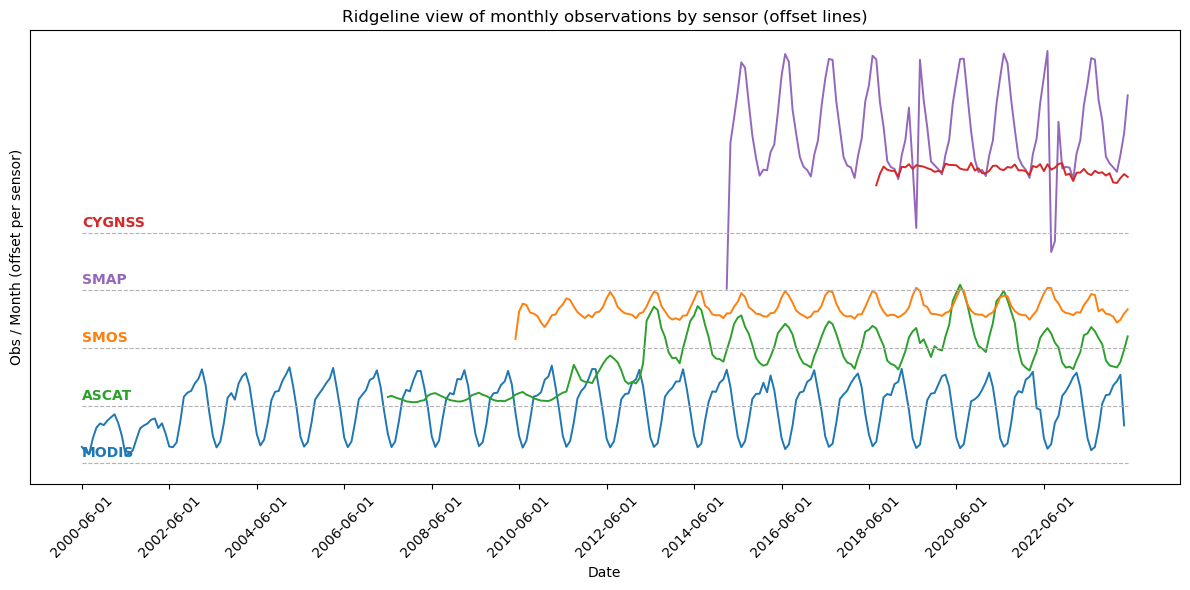

In [7]:
# Ridgeline/offset line plot per sensor (palette colors)
palette = {"MODIS": '#1f77b4', "ASCAT": '#2ca02c', "SMOS": '#ff7f0e', "SMAP": '#9467bd', "CYGNSS": '#d62728'}
order = ['MODIS', 'ASCAT', 'SMOS', 'SMAP', 'CYGNSS']
step = 1200000
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
for i, g in enumerate(order):
    if g not in combined_plot:
        continue
    offset = i * step
    arr = combined_plot[g]
    arr_plot = np.where(np.isfinite(arr), arr, np.nan)
    ax.plot(target_dates_plot, arr_plot + offset, label=g, color=palette.get(g, 'gray'), lw=1.4)
    ax.hlines(offset, target_dates_plot.min(), target_dates_plot.max(), colors='0.7', linestyles='--', linewidth=0.8)
    ax.text(target_dates_plot.min(), offset + step*0.05, g, fontsize=10, ha='left', va='bottom', color=palette.get(g, 'gray'), fontweight='bold')
ax.set_ylabel('Obs / Month (offset per sensor)')
ax.set_xlabel('Date')
ax.set_yticks([])
ax.set_xticks(target_dates_plot[::max(len(target_dates_plot)//12,1)])
ax.tick_params(axis='x', rotation=45)
ax.set_title('Ridgeline view of monthly observations by sensor (offset lines)')
plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_40792/696819472.py:34: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  axes[-1].set_xticks(pd.date_range(x_min, x_max, freq='2AS'))


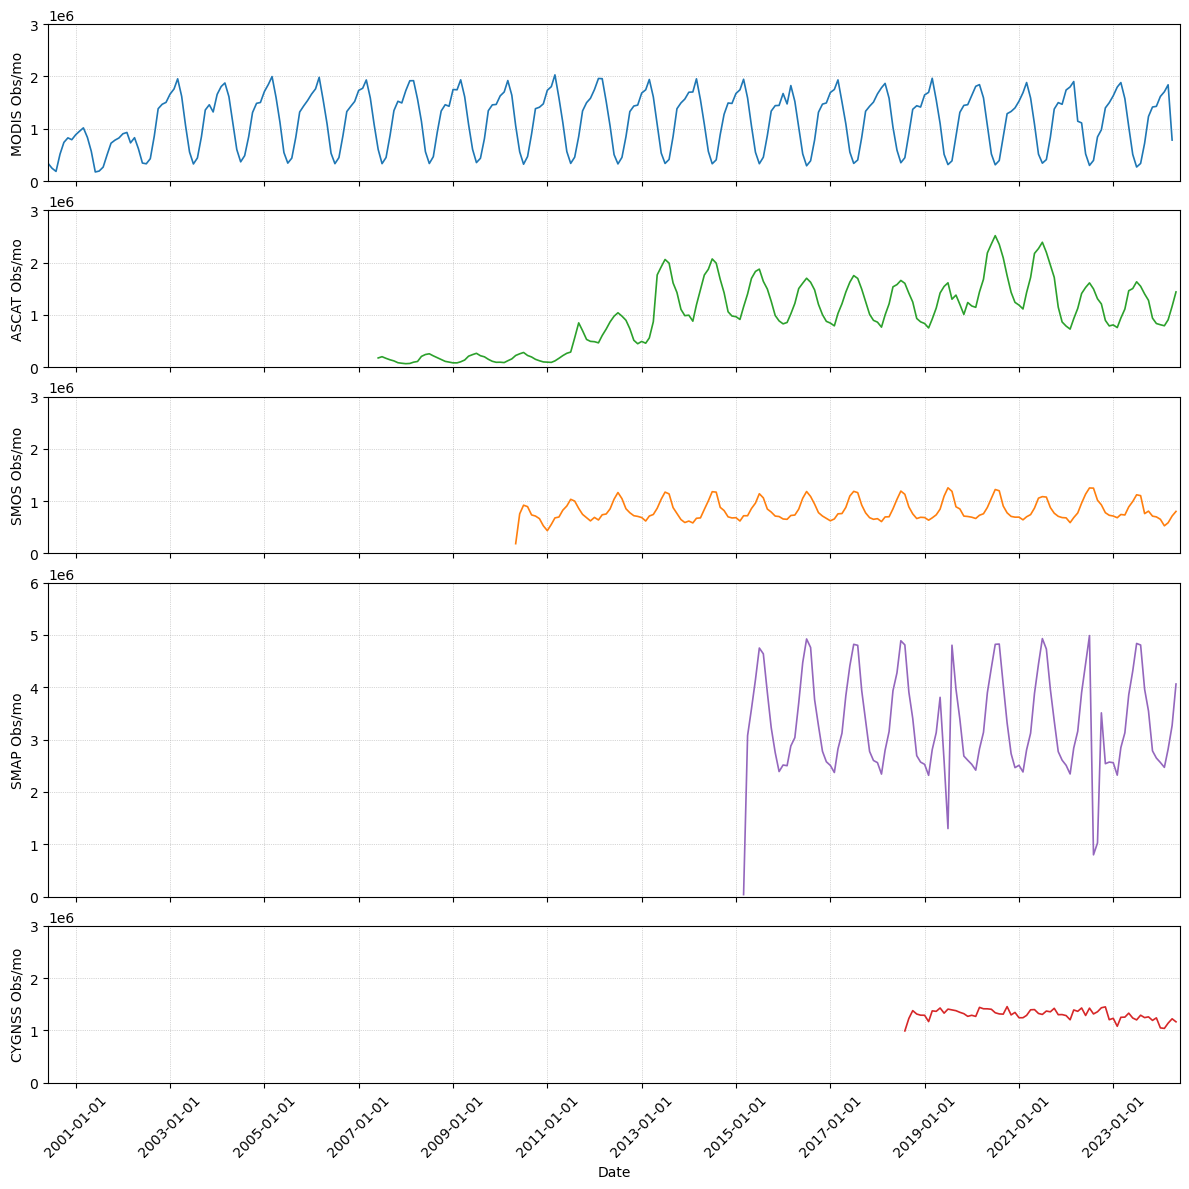

In [8]:
# Per-sensor panels with uniform x-axis (2000-06-01 to 2024-06-01)
height_ratios = [1, 1, 1, 2, 1]  # double height for SMAP panel
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True, height_ratios=height_ratios)
x_min = pd.Timestamp('2000-06-01')
x_max = pd.Timestamp('2024-06-01')

sensor_order = ['MODIS', 'ASCAT', 'SMOS', 'SMAP', 'CYGNSS']
colors = {
    'MODIS': '#1f77b4',
    'ASCAT': '#2ca02c',
    'SMOS': '#ff7f0e',
    'SMAP': '#9467bd',
    'CYGNSS': '#d62728',
}

ymin_default, ymax_default = 0, 3e6
ymin_smap, ymax_smap = 0, 6e6

for ax, sensor in zip(axes, sensor_order):
    if sensor not in combined_plot:
        ax.set_visible(False)
        continue
    arr = combined_plot[sensor]
    ax.plot(target_dates_plot, arr, color=colors.get(sensor, 'gray'), lw=1.2)
    ax.set_ylabel(f"{sensor} Obs/mo")
    ax.set_xlim(x_min, x_max)
    if sensor == 'SMAP':
        ax.set_ylim(ymin_smap, ymax_smap)
    else:
        ax.set_ylim(ymin_default, ymax_default)
    ax.grid(True, linestyle=':', linewidth=0.5)

axes[-1].set_xlabel('Date')
axes[-1].set_xticks(pd.date_range(x_min, x_max, freq='2AS'))
axes[-1].tick_params(axis='x', rotation=45)
for ax in axes[:-1]:
    ax.tick_params(labelbottom=False)

plt.tight_layout(h_pad=0.4)
plt.show()

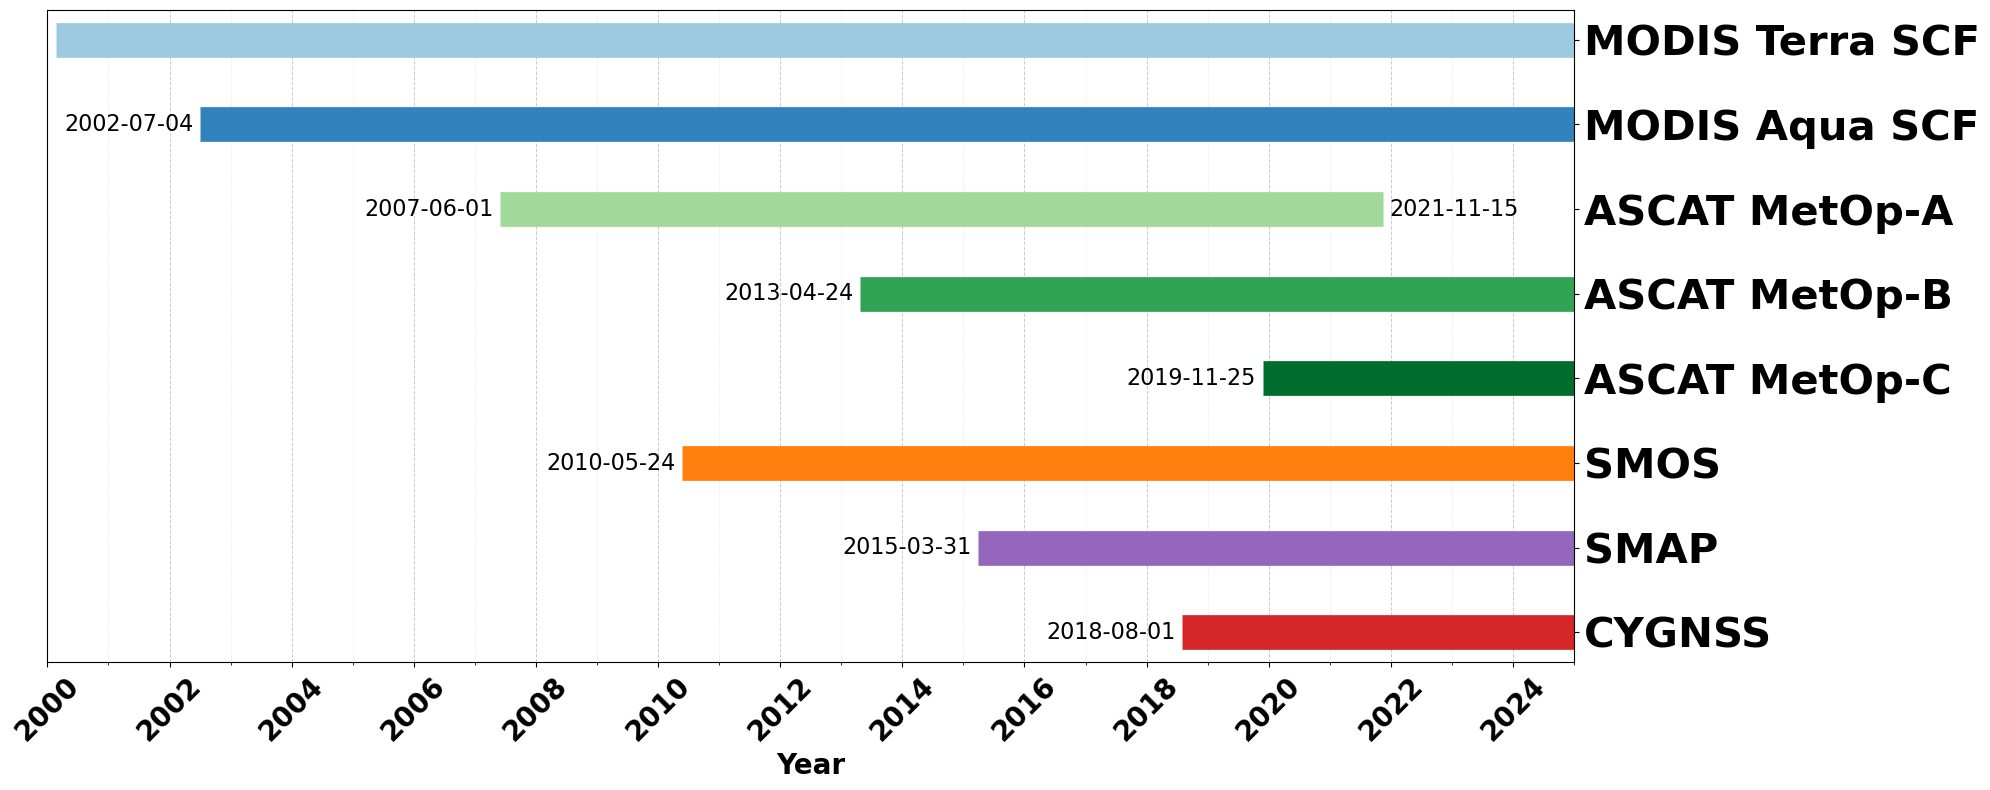

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# --- Axes window ---
AX_START = dt.date(2000, 1, 1)
AX_END   = dt.date(2025, 1, 1)

# --- Experiment window (just show; do NOT clip lines) ---
EXP_START = dt.date(2000, 6, 1)
EXP_END   = dt.date(2024, 5, 30)

# --- Availability (full, un-clipped) ---
sensors = {
    "ASCAT MetOp-A": (dt.date(2007, 6, 1),  dt.date(2021, 11, 15)),
    "ASCAT MetOp-B": (dt.date(2013, 4, 24), dt.date(2100, 1, 1)),
    "ASCAT MetOp-C": (dt.date(2019, 11, 25),dt.date(2100, 1, 1)),
    "MODIS Terra SCF": (dt.date(2000, 2, 24), dt.date(2100, 1, 1)),
    "MODIS Aqua SCF":  (dt.date(2002, 7, 4),  dt.date(2100, 1, 1)),
    "SMOS": (dt.date(2010, 5, 24), dt.date(2100, 1, 1)),
    "SMAP": (dt.date(2015, 3, 31), dt.date(2100, 1, 1)),
    "CYGNSS": (dt.date(2018, 8, 1), dt.date(2100, 1, 1)),
}

# --- Colors: 3 greens (ASCAT), 2 blues (MODIS), orange (SMOS), purple (SMAP) ---
colors = {
    "ASCAT MetOp-A": "#a1d99b",
    "ASCAT MetOp-B": "#31a354",
    "ASCAT MetOp-C": "#006d2c",
    "MODIS Terra SCF": "#9ecae1",
    "MODIS Aqua SCF":  "#3182bd",
    "SMOS": "#ff7f0e",
    "SMAP": "#9467bd",
    "CYGNSS": "#d62728",
}

# Desired order top → bottom
order = [
    "CYGNSS",
    "SMAP",
    "SMOS",
    "ASCAT MetOp-C",  # C
    "ASCAT MetOp-B",  # B
    "ASCAT MetOp-A",  # A
    "MODIS Aqua SCF", # Aqua
    "MODIS Terra SCF" # Terra
]

def fmt(d):
    return d.strftime("%Y-%m-%d")

fig, ax = plt.subplots(figsize=(20, 8))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Shade/mark the experiment period (display only)
# ax.axvspan(EXP_START, EXP_END, alpha=0.08)
# ax.axvline(EXP_START, linestyle="--", linewidth=1)
# ax.axvline(EXP_END,   linestyle="--", linewidth=1)

# Plot thick line segments (no clipping)
for i, name in enumerate(order):
    s, e = sensors[name]
    ax.plot([s, e], [i, i], linewidth=25, solid_capstyle="butt", color=colors[name])

    # --- Annotations ---
    pad = dt.timedelta(days=40)
    # Start date for all EXCEPT Terra
    if name != "MODIS Terra SCF":
        ax.text(s - pad, i, fmt(s), va="center", ha="right", fontsize=16,
                bbox=dict(boxstyle="round,pad=0.2", fc="none", ec="none", alpha=0.85))
    # End date ONLY for MetOp-A
    if name == "ASCAT MetOp-A":
        ax.text(e + pad, i, fmt(e), va="center", ha="left", fontsize=16,
                bbox=dict(boxstyle="round,pad=0.2", fc='none', ec="none", alpha=0.85))

# Y-axis labels in the specified order
ax.set_yticks(range(len(order)))
ax.set_yticklabels(order)
ax.yaxis.tick_right()
ax.tick_params(labelleft=False, labelright=True)
ax.tick_params(axis="y", labelsize=30)
for lbl in ax.get_yticklabels():
    lbl.set_fontweight("bold")

# X-axis limits & formatting
ax.set_xlim(AX_START, AX_END)
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # ticks every 2 years
ax.xaxis.set_minor_locator(mdates.YearLocator())        # yearly minor ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# put grid behind everything
ax.set_axisbelow(True)

# light vertical grid lines (both major + minor ticks)
ax.grid(axis="x", which="major", linestyle="--", linewidth=0.7, alpha=0.65)
ax.grid(axis="x", which="minor", linestyle=":",  linewidth=0.5, alpha=0.45)

ax.tick_params(axis="x", labelsize=20, rotation=45)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")
ax.set_xlabel("Year", fontsize=20, fontweight="bold")
#ax.set_title("Sensor Availability; Experiment window marked", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

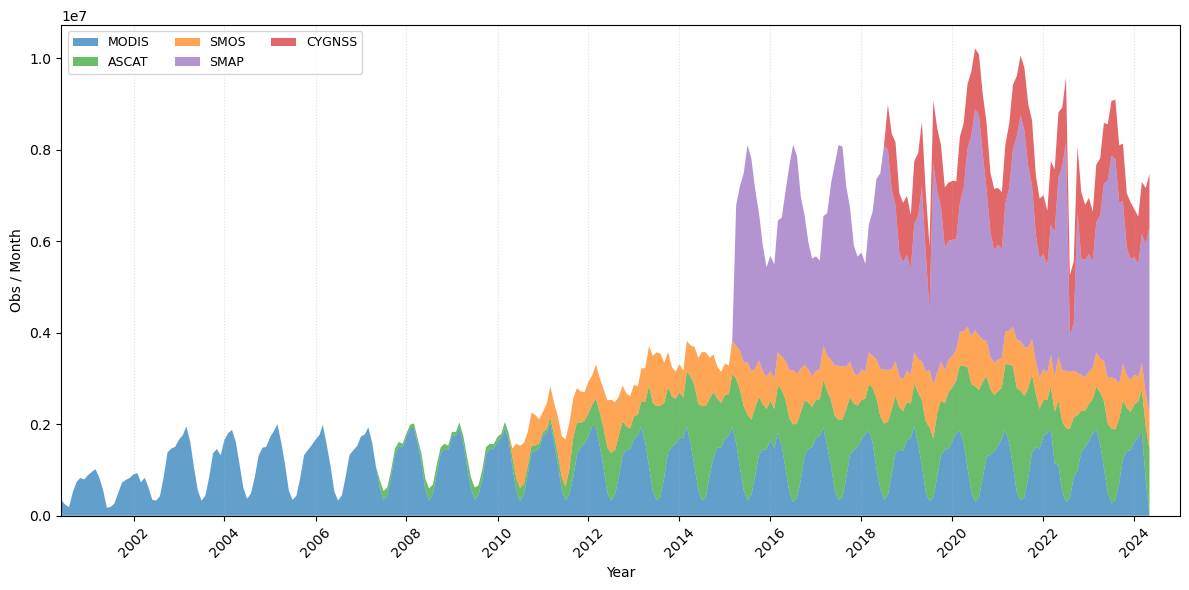

In [10]:
# Stacked area only with gantt-style x ticks
import matplotlib.dates as mdates

palette = {'MODIS': '#1f77b4', 'ASCAT': '#2ca02c', 'SMOS': '#ff7f0e', 'SMAP': '#9467bd', 'CYGNSS': '#d62728'}
series_order = ['MODIS', 'ASCAT', 'SMOS', 'SMAP', 'CYGNSS']
stack_data = []
labels = []
for g in series_order:
    if g in combined_plot:
        arr = combined_plot[g]
        filled = np.where(np.isfinite(arr), arr, 0.0)
        stack_data.append(filled)
        labels.append(g)

fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(target_dates_plot, stack_data, labels=labels, colors=[palette[g] for g in labels], alpha=0.7)
ax.set_xlim(pd.Timestamp('2000-06-01'), pd.Timestamp('2025-01-01'))
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Obs / Month')
ax.set_xlabel('Year')
ax.legend(ncol=3, fontsize=9)
ax.grid(True, axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


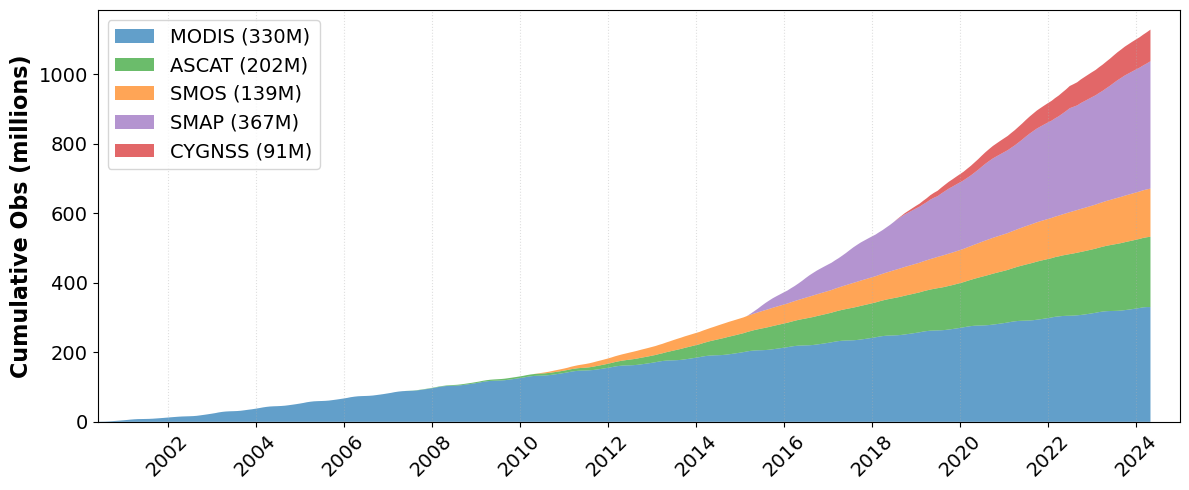

In [29]:
# Cumulative stacked area (running sum)
import matplotlib.dates as mdates

palette = {'MODIS': '#1f77b4', 'ASCAT': '#2ca02c', 'SMOS': '#ff7f0e', 'SMAP': '#9467bd', 'CYGNSS': '#d62728'}
series_order = ['MODIS', 'ASCAT', 'SMOS', 'SMAP', 'CYGNSS']
stack_data = []
labels = []
for g in series_order:
    if g in combined_plot:
        arr = combined_plot[g]
        filled = np.where(np.isfinite(arr), arr, 0.0)
        cumulative = filled.cumsum() / 1e6  # millions
        stack_data.append(cumulative)
        labels.append(g)

# build labels with cumulative totals (millions)
label_with_total = []
for g, arr in zip(labels, stack_data):
    total_m = float(np.nanmax(arr)) if hasattr(arr, "__len__") else 0.0
    label_with_total.append(f"{g} ({total_m:.0f}M)")

fig, ax = plt.subplots(figsize=(12, 5))
ax.stackplot(target_dates_plot, stack_data, labels=label_with_total, colors=[palette[g.split()[0]] for g in label_with_total], alpha=0.7)
ax.set_xlim(pd.Timestamp('2000-06-01'), pd.Timestamp('2025-01-01'))
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Cumulative Obs (millions)', fontsize=16, fontweight='bold')
ax.legend(ncol=1, fontsize=14)
ax.grid(True, axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()
# adjust y-limits based on millions scale
max_total = 0
for arr in stack_data:
    max_total = max(max_total, float(np.nanmax(arr)) if hasattr(arr, "__len__") else 0)
#ax.set_ylim(0, max_total*1.05 if max_total>0 else None)
plt.show()
